# Example: MMNL Assortment Optimization (Unconstrained)

This notebook demonstrates how to test an algorithm for the hard instances of the ** Mixed Multinomial Logit (MMNL)** choice model under the unconstrained setting.

It shows how to:
1. Load the instance
2. Run a method for the instances
3. Interpret the results provided by the algorithms.

## 1. Import Required Modules


In [1]:
import sys
import os
import json

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)  # get the project root directory
sys.path.append(project_root)

from generator.mmnl_data_generator import *
from generator.utils  import *
from generator.constraint import *
from models.mmnl_functions import *
from method.mmnl_method import *
from method.general_method import *

%load_ext autoreload
%autoreload 2
print("✅ Modules imported successfully.")

✅ Modules imported successfully.


## 2. Unconstrained Assortment Optimization

In this section, we solve the assortment optimization problem without any additional constraints. 

### 2.1 Load Data
- We provide two json files in the hard_data file based on different revenue curves
- The number of products $n \in \{50, 100, 200\}$
- The number of customer segements $m \in \{5, 10, 25\}$
- The revenue curves include RS2 and RS4

In [ ]:
hard_instance_dir = project_root + "/hard_data/"
rev_method = 'RS2'
unconstrained_dir = "mmnl_unconstrained_"
# cardinality_dir = "mmnl_card_"
input_json_path = hard_instance_dir + unconstrained_dir + rev_method + "_data.json"
instances = load_MMNL_instances(input_json_path)

DATASET STRUCTURE SUMMARY


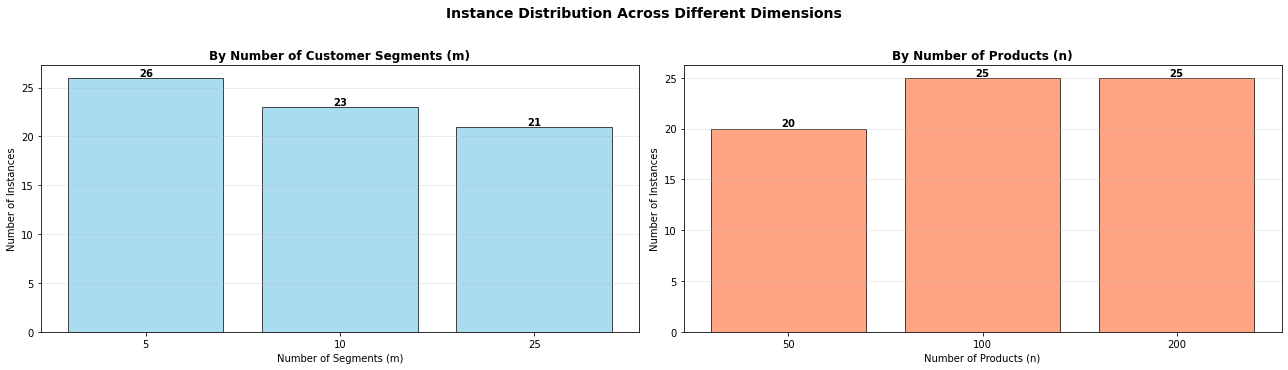

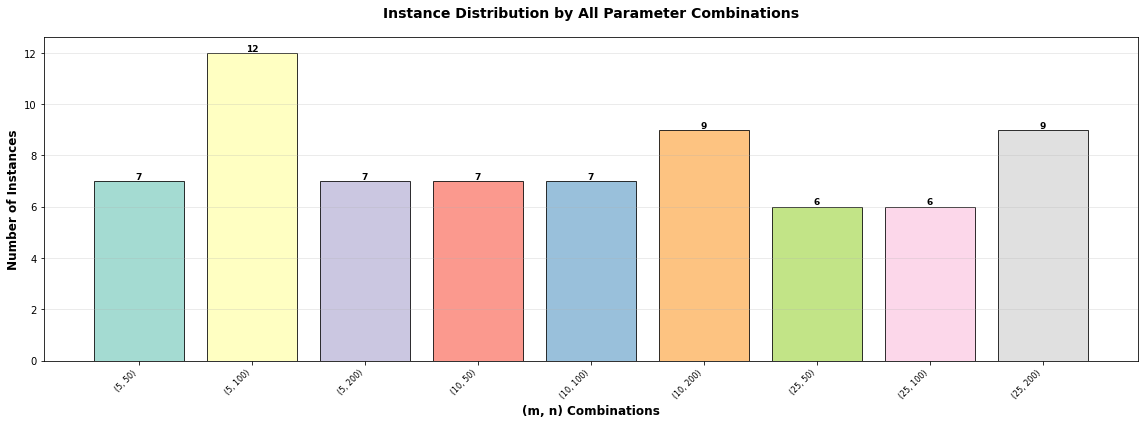

In [3]:
# =============================================================================
# DATA SUMMARY: Group Statistics with Bar Plot
# =============================================================================

print("=" * 80)
print("DATASET STRUCTURE SUMMARY")
print("=" * 80)

# Create summary DataFrame
df_summary = pd.DataFrame([
    {
        'm': inst.m,
        'n': inst.n,
        'cap_rate': inst.cap_rate,
        'seed': inst.seed
    }
    for inst in instances
])

# Group by (m, n, cap_rate) and count
grouped = df_summary.groupby(['m', 'n', 'cap_rate']).size().reset_index(name='num_instances')

# Create bar plot visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Instance Distribution Across Different Dimensions', 
             fontsize=14, fontweight='bold', y=1.02)

# Subplot 1: Distribution by m (number of segments)
m_counts = df_summary['m'].value_counts().sort_index()
axes[0].bar(m_counts.index.astype(str), m_counts.values, 
            color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('By Number of Customer Segments (m)', fontweight='bold')
axes[0].set_xlabel('Number of Segments (m)')
axes[0].set_ylabel('Number of Instances')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(m_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Subplot 2: Distribution by n (number of products)
n_counts = df_summary['n'].value_counts().sort_index()
axes[1].bar(n_counts.index.astype(str), n_counts.values, 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('By Number of Products (n)', fontweight='bold')
axes[1].set_xlabel('Number of Products (n)')
axes[1].set_ylabel('Number of Instances')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(n_counts.values):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.show()

# Additional grouped bar plot by (m, n, cap_rate) combinations
fig, ax = plt.subplots(figsize=(16, 6))

# Create labels for each combination
grouped['label'] = grouped.apply(
    lambda row: f"({int(row['m'])}, {int(row['n'])})", 
    axis=1
)

# Create bar plot
x_pos = np.arange(len(grouped))
bars = ax.bar(x_pos, grouped['num_instances'], 
              color=plt.cm.Set3(np.arange(len(grouped)) % 12),
              edgecolor='black', alpha=0.8)

# Customize plot
ax.set_xlabel('(m, n) Combinations', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
ax.set_title('Instance Distribution by All Parameter Combinations', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(grouped['label'], rotation=45, ha='right', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, (bar, val) in enumerate(zip(bars, grouped['num_instances'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            str(val), ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

### 2.2 Demonstrate the Structure of the Instance

INSTANCE OVERVIEW
Number of customer segments (m): 5
Number of products (n): 50
Random seed: 3
Capacity rate: 1
Maximum revenue (optimal): 0.4327

DATA COMPONENTS - DIMENSIONS

1. Utility Matrix (u)
   Shape: (5, 50)
   Description: Rows = customer segments, Columns = products
   Each entry u[i,j] represents the utility of product j for segment i

2. Product Prices (price)
   Shape: (1, 50)
   Range: [0.2000, 1.0000]
   Description: Revenue generated when a product is purchased

3. No-Purchase Option Utility (v0)
   Shape: (5,)
   Description: Utility of not purchasing for each segment
   Higher v0 means customers are more likely to leave without buying

4. Customer Segment Probabilities (omega)
   Shape: (5,)
   Description: Probability distribution over customer segments
   Sum: 1.0000 (should be 1.0)

DATA VISUALIZATION


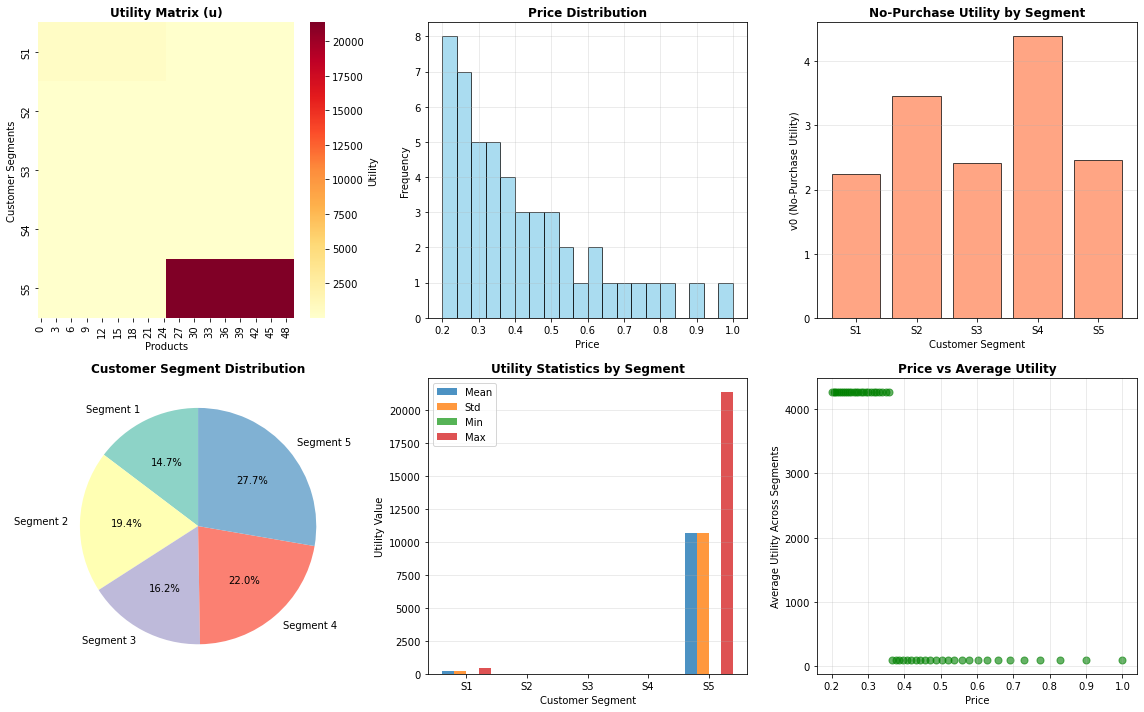


SUMMARY STATISTICS

Utility Matrix Statistics:
  Mean: 2181.5255
  Std: 6392.2975
  Min: 0.0005
  Max: 21354.0896

Price Statistics:
  Mean: 0.4183
  Std: 0.1930
  Min: 0.2000
  Max: 1.0000

No-Purchase Utility Statistics:
  Mean: 2.9911
  Std: 0.8195
  Min: 2.2358
  Max: 4.3880


In [6]:
# =============================================================================
#  LOAD AND EXPLORE A SINGLE INSTANCE
# =============================================================================

# Select one instance for detailed demonstration
data = instances[3]  # Using the fourth instance as an example

# -----------------------------------------------------------------------------
# Display Basic Instance Information
# -----------------------------------------------------------------------------
print("=" * 80)
print("INSTANCE OVERVIEW")
print("=" * 80)
print(f"Number of customer segments (m): {data.m}")
print(f"Number of products (n): {data.n}")
print(f"Random seed: {data.seed}")
print(f"Capacity rate: {data.cap_rate}")
print(f"Maximum revenue (optimal): {data.max_rev:.4f}")


# -----------------------------------------------------------------------------
# Display Data Structure and Dimensions
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("DATA COMPONENTS - DIMENSIONS")
print("=" * 80)

# Flatten arrays to ensure 1-dimensional format for later processing
price_1d = data.price.flatten() if len(data.price.shape) > 1 else data.price
v0_1d = data.v0.flatten() if len(data.v0.shape) > 1 else data.v0
omega_1d = data.omega.flatten() if len(data.omega.shape) > 1 else data.omega

# 1. Utility Matrix
print(f"\n1. Utility Matrix (u)")
print(f"   Shape: {data.u.shape}")
print(f"   Description: Rows = customer segments, Columns = products")
print(f"   Each entry u[i,j] represents the utility of product j for segment i")

# 2. Product Prices
print(f"\n2. Product Prices (price)")
print(f"   Shape: {data.price.shape}")
print(f"   Range: [{price_1d.min():.4f}, {price_1d.max():.4f}]")
print(f"   Description: Revenue generated when a product is purchased")

# 3. No-Purchase Option Utility
print(f"\n3. No-Purchase Option Utility (v0)")
print(f"   Shape: {data.v0.shape}")
print(f"   Description: Utility of not purchasing for each segment")
print(f"   Higher v0 means customers are more likely to leave without buying")

# 4. Customer Segment Probabilities
print(f"\n4. Customer Segment Probabilities (omega)")
print(f"   Shape: {data.omega.shape}")
print(f"   Description: Probability distribution over customer segments")
print(f"   Sum: {omega_1d.sum():.4f} (should be 1.0)")

# -----------------------------------------------------------------------------
# Visualize the Data
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("DATA VISUALIZATION")
print("=" * 80)

# Create a comprehensive figure with 6 subplots
fig = plt.figure(figsize=(16, 10))

# Subplot 1: Utility Matrix Heatmap
# Shows the utility values across all segments and products
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(data.u, cmap='YlOrRd', cbar_kws={'label': 'Utility'}, ax=ax1)
ax1.set_title('Utility Matrix (u)', fontweight='bold')
ax1.set_xlabel('Products')
ax1.set_ylabel('Customer Segments')
ax1.set_yticks(np.arange(data.m) + 0.5)      
ax1.set_yticklabels([f'S{i+1}' for i in range(data.m)])

# Subplot 2: Price Distribution
# Shows how product prices are distributed
ax2 = plt.subplot(2, 3, 2)
ax2.hist(price_1d, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
ax2.set_title('Price Distribution', fontweight='bold')
ax2.set_xlabel('Price')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

# Subplot 3: No-Purchase Utility by Segment
# Compares the tendency to not purchase across different segments
ax3 = plt.subplot(2, 3, 3)
ax3.bar(range(data.m), v0_1d, edgecolor='black', alpha=0.7, color='coral')
ax3.set_title('No-Purchase Utility by Segment', fontweight='bold')
ax3.set_xlabel('Customer Segment')
ax3.set_ylabel('v0 (No-Purchase Utility)')
ax3.set_xticks(range(data.m))
ax3.set_xticklabels([f'S{i+1}' for i in range(data.m)])
ax3.grid(True, alpha=0.3, axis='y')

# Subplot 4: Customer Segment Distribution
# Shows the relative importance of each customer segment
ax4 = plt.subplot(2, 3, 4)
colors = plt.cm.Set3(range(data.m))
ax4.pie(omega_1d, labels=[f'Segment {i+1}' for i in range(data.m)], 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax4.set_title('Customer Segment Distribution', fontweight='bold')

# Subplot 5: Utility Statistics by Segment
# Summarizes utility characteristics for each customer segment
ax5 = plt.subplot(2, 3, 5)
utility_stats = pd.DataFrame({
    'Mean': data.u.mean(axis=1),
    'Std': data.u.std(axis=1),
    'Min': data.u.min(axis=1),
    'Max': data.u.max(axis=1)
})
x = np.arange(data.m)
width = 0.2
ax5.bar(x - width*1.5, utility_stats['Mean'], width, label='Mean', alpha=0.8)
ax5.bar(x - width*0.5, utility_stats['Std'], width, label='Std', alpha=0.8)
ax5.bar(x + width*0.5, utility_stats['Min'], width, label='Min', alpha=0.8)
ax5.bar(x + width*1.5, utility_stats['Max'], width, label='Max', alpha=0.8)
ax5.set_title('Utility Statistics by Segment', fontweight='bold')
ax5.set_xlabel('Customer Segment')
ax5.set_ylabel('Utility Value')
ax5.set_xticks(x)
ax5.set_xticklabels([f'S{i+1}' for i in range(data.m)])
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Subplot 6: Price vs Average Utility
# Explores the relationship between price and utility
ax6 = plt.subplot(2, 3, 6)
avg_utility = data.u.mean(axis=0)
ax6.scatter(price_1d, avg_utility, alpha=0.6, s=50, color='green')
ax6.set_title('Price vs Average Utility', fontweight='bold')
ax6.set_xlabel('Price')
ax6.set_ylabel('Average Utility Across Segments')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Summary Statistics
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

print(f"\nUtility Matrix Statistics:")
print(f"  Mean: {data.u.mean():.4f}")
print(f"  Std: {data.u.std():.4f}")
print(f"  Min: {data.u.min():.4f}")
print(f"  Max: {data.u.max():.4f}")

print(f"\nPrice Statistics:")
print(f"  Mean: {price_1d.mean():.4f}")
print(f"  Std: {price_1d.std():.4f}")
print(f"  Min: {price_1d.min():.4f}")
print(f"  Max: {price_1d.max():.4f}")

print(f"\nNo-Purchase Utility Statistics:")
print(f"  Mean: {v0_1d.mean():.4f}")
print(f"  Std: {v0_1d.std():.4f}")
print(f"  Min: {v0_1d.min():.4f}")
print(f"  Max: {v0_1d.max():.4f}")

### 2.3 Run Algorithm on All Instances

In [7]:
# Initialize data paths and result storage
hard_instance_dir = project_root + "/hard_data/"
rev_method_list = ['RS2', 'RS4']  # Two revenue curve methods to test
results = []

# Loop through each revenue method
for rev_method in rev_method_list:
    # Load instances for the current revenue method
    input_json_path = hard_instance_dir + unconstrained_dir + rev_method + "_data.json"
    instances = load_MMNL_instances(input_json_path)
    
    print(f"\nProcessing {rev_method}...")
    
    # Process each instance
    for idx, data in enumerate(instances):
        # Get the revenue function for this instance
        revenue_fn = get_revenue_function_mmnl(data)
        
        # Run the revenue-ordered heuristic algorithm
        # rev_order: best revenue found
        # k: number of products selected
        # best_ass: best assortment found (binary vector)
        rev_order, k, best_ass = revenue_order('mmnl', data)
        
        # Calculate again the revenue achieved by the heuristic
        revenue = revenue_fn(best_ass)[0]
        
        # Get the optimal revenue (from exact solution)
        opt_rev = data.max_rev
        
        # Calculate the optimality gap (in percentage)
        gap_method = (opt_rev - revenue) / opt_rev * 100
        
        # Store results for this instance
        result_dict = {
            'm': data.m,                    # Number of customer segments
            'n': data.n,                    # Number of products
            'rev_method': rev_method,       # Revenue curve method (RS2 or RS4)
            'cap_rate': data.cap_rate,      # Capacity rate
            'seed': data.seed,              # Random seed for reproducibility
            'max_rev': opt_rev,             # Optimal revenue
            'gap_method': gap_method        # Optimality gap (%)
        }
        
        results.append(result_dict)

print(f"\n✅ Completed testing on {len(results)} instances.")


Processing RS2...

Processing RS4...

✅ Completed testing on 156 instances.


### 2.4 Analyze and Visualize Results

In [9]:
# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)

# Create a combined column for (m, n) pairs for easier grouping
df_results['m_n'] = df_results['m'].astype(str) + '_' + df_results['n'].astype(str)

# Display basic statistics
print("\n" + "=" * 80)
print("RESULTS OVERVIEW")
print("=" * 80)
print(f"Total instances tested: {len(df_results)}")
print(f"Revenue methods: {df_results['rev_method'].unique().tolist()}")
print(f"(m, n) combinations: {sorted(df_results['m_n'].unique().tolist())}")
print(f"\nOverall gap statistics:")
print(df_results['gap_method'].describe().round(4))


RESULTS OVERVIEW
Total instances tested: 156
Revenue methods: ['RS2', 'RS4']
(m, n) combinations: ['10_100', '10_200', '10_50', '25_100', '25_200', '25_50', '5_100', '5_200', '5_50']

Overall gap statistics:
count    156.0000
mean       7.1992
std        6.1108
min       -0.0000
25%        0.0000
50%        8.1786
75%       11.8366
max       21.8799
Name: gap_method, dtype: float64


### 2.5 Save Detailed Statistics to Excel

In [70]:
# Create output directory if it doesn't exist
output_dir = project_root + "/results/"
os.makedirs(output_dir, exist_ok=True)

# Save comprehensive statistics to Excel file
with pd.ExcelWriter(output_dir + 'mmnl_summary_statistics.xlsx', engine='openpyxl') as writer:
    # Sheet 1: All raw results
    df_results.to_excel(writer, sheet_name='All Results', index=False)
    
    # Create separate sheets for each revenue method
    for rev_method in df_results['rev_method'].unique():
        df_rev = df_results[df_results['rev_method'] == rev_method]
        
        # Sheet: Mean gap by (m, n)
        pivot_mean = df_rev.pivot_table(
            values='gap_method', 
            index='m',          # Rows: number of segments
            columns='n',        # Columns: number of products
            aggfunc='mean'
        )
        pivot_mean.to_excel(writer, sheet_name=f'{rev_method}_Mean')
        
        # Sheet: Standard deviation of gap by (m, n)
        pivot_std = df_rev.pivot_table(
            values='gap_method', 
            index='m', 
            columns='n', 
            aggfunc='std'
        )
        pivot_std.to_excel(writer, sheet_name=f'{rev_method}_Std')
        
        # Sheet: Detailed statistics for each (m, n) combination
        summary_by_mn = df_rev.groupby('m_n')['gap_method'].describe()
        summary_by_mn.to_excel(writer, sheet_name=f'{rev_method}_Details')
    
    # Sheet: Side-by-side comparison of both revenue methods
    pivot_comparison = df_results.pivot_table(
        values='gap_method',
        index=['m', 'n'],
        columns='rev_method',
        aggfunc='mean'
    )
    pivot_comparison.to_excel(writer, sheet_name='Comparison')

print(f"✅ Summary statistics saved to {output_dir}mmnl_summary_statistics.xlsx")

✅ Summary statistics saved to /Users/miracleletter/Library/Mobile Documents/com~apple~CloudDocs/code/Assortment Benchmark/results/mmnl_summary_statistics.xlsx


### 2.6 Visualize Algorithm Performance

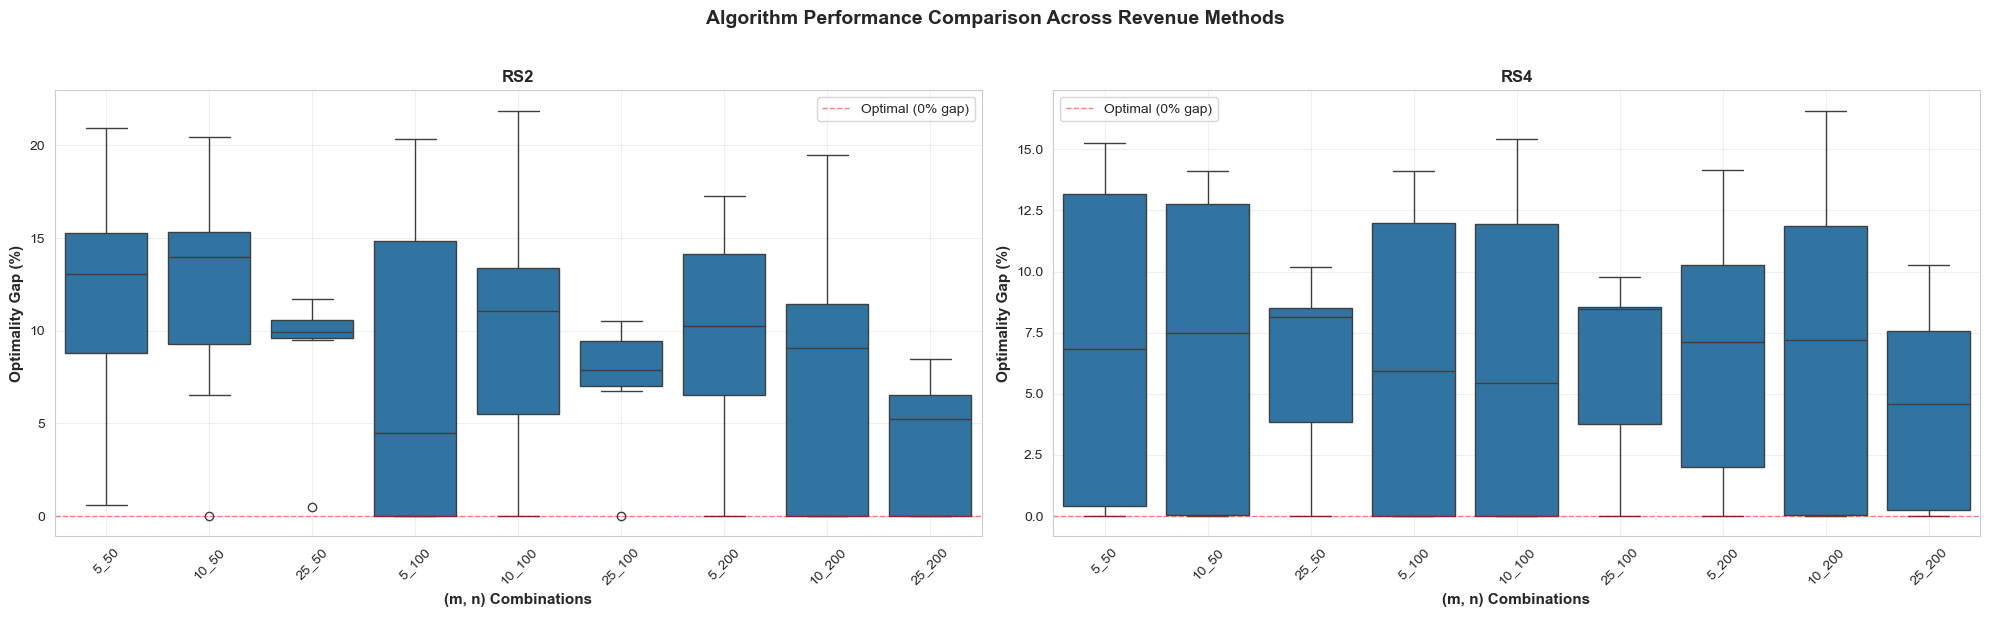


INTERPRETATION GUIDE
• Lower gap values indicate better algorithm performance
• Box shows the interquartile range (25th to 75th percentile)
• Line inside box represents the median
• Whiskers show the full range (excluding outliers)
• Points beyond whiskers are outliers


In [71]:
# -----------------------------------------------------------------------------
# Visualization 1: Side-by-Side Comparison by Revenue Method
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
rev_methods = df_results['rev_method'].unique()

for idx, rev_method in enumerate(rev_methods):
    df_rev = df_results[df_results['rev_method'] == rev_method]
    
    # Create boxplot showing gap distribution for each (m, n) combination
    sns.boxplot(data=df_rev, x='m_n', y='gap_method', ax=axes[idx])
    
    # Customize plot appearance
    axes[idx].set_xlabel('(m, n) Combinations', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Optimality Gap (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{rev_method}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add reference line at 0% gap (perfect solution)
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1, 
                      label='Optimal (0% gap)')
    axes[idx].legend()

plt.suptitle('Algorithm Performance Comparison Across Revenue Methods', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print interpretation guide
print("\n" + "=" * 80)
print("INTERPRETATION GUIDE")
print("=" * 80)
print("• Lower gap values indicate better algorithm performance")
print("• Box shows the interquartile range (25th to 75th percentile)")
print("• Line inside box represents the median")
print("• Whiskers show the full range (excluding outliers)")
print("• Points beyond whiskers are outliers")

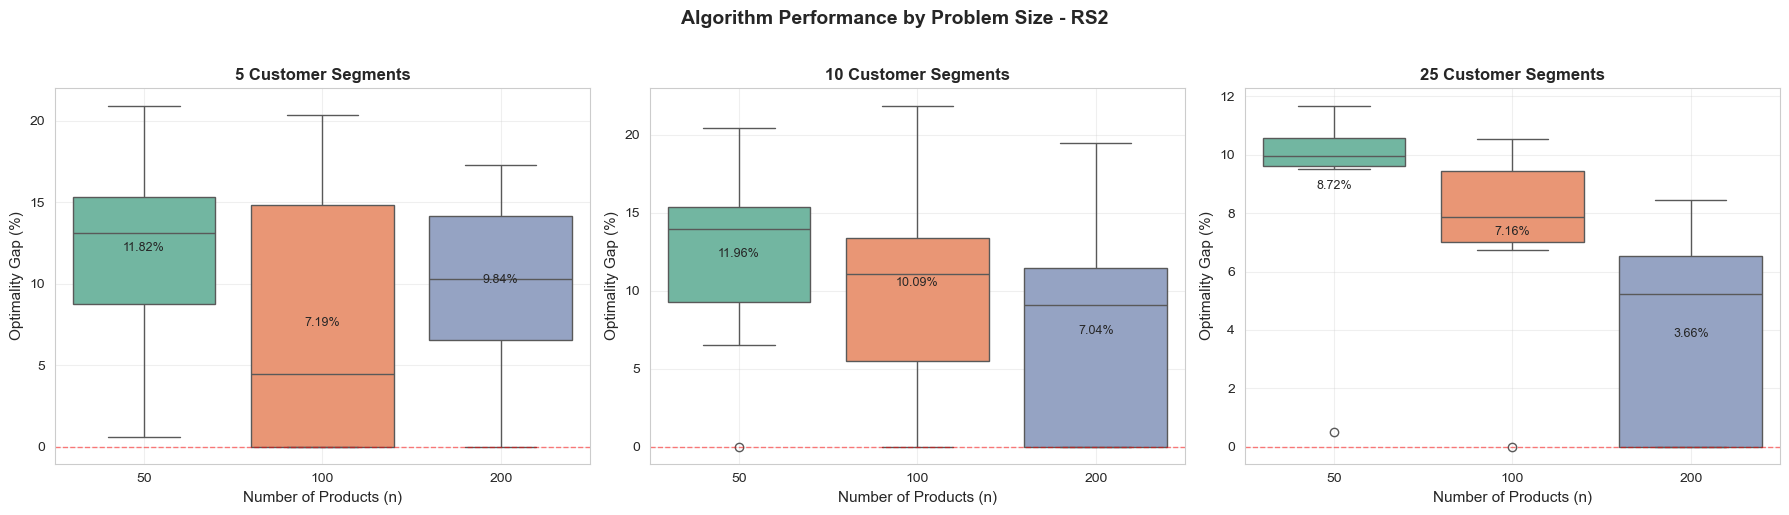


RS2 Performance Summary:
           mean     std     min      max
m  n                                    
5  50   11.8223  6.7242  0.6007  20.9284
   100   7.1886  7.7888 -0.0000  20.3272
   200   9.8360  6.4575  0.0000  17.2586
10 50   11.9587  6.7341 -0.0000  20.4424
   100  10.0899  7.8479 -0.0000  21.8799
   200   7.0450  7.2681 -0.0000  19.4973
25 50    8.7221  4.1059  0.4899  11.6883
   100   7.1574  3.7813  0.0000  10.5294
   200   3.6632  3.6089 -0.0000   8.4599


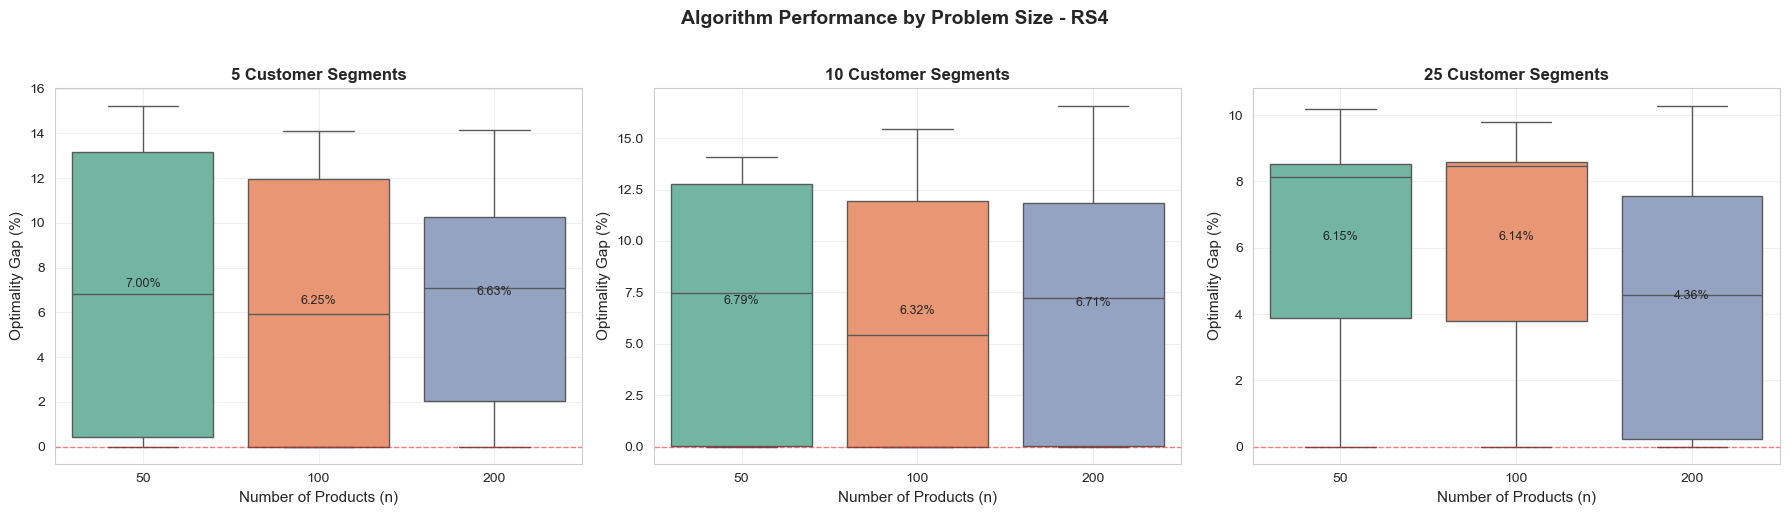


RS4 Performance Summary:
          mean     std  min      max
m  n                                
5  50   7.0010  6.7018 -0.0  15.2479
   100  6.2545  6.2084 -0.0  14.1070
   200  6.6329  5.2709 -0.0  14.1407
10 50   6.7887  6.4926  0.0  14.1026
   100  6.3206  6.7522 -0.0  15.4360
   200  6.7050  6.4404 -0.0  16.5832
25 50   6.1525  4.2709 -0.0  10.1689
   100  6.1364  4.2413 -0.0   9.7788
   200  4.3649  4.1117 -0.0  10.2883


In [73]:
# -----------------------------------------------------------------------------
# Visualization 2: Detailed Analysis by Number of Segments
# -----------------------------------------------------------------------------

# Create separate figures for each revenue method
for rev_method in rev_methods:
    df_rev = df_results[df_results['rev_method'] == rev_method]
    
    # Create subplots for different values of m (number of segments)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Algorithm Performance by Problem Size - {rev_method}', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    m_values = sorted(df_rev['m'].unique())
    
    for idx, m_val in enumerate(m_values):
        # Filter data for this specific m value
        df_m = df_rev[df_rev['m'] == m_val]
        
        # Create boxplot showing how performance varies with number of products
        sns.boxplot(data=df_m, x='n', y='gap_method', hue='n', 
                    ax=axes[idx], palette='Set2', legend=False)
        
        # Customize subplot
        axes[idx].set_title(f'{m_val} Customer Segments', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Number of Products (n)', fontsize=11)
        axes[idx].set_ylabel('Optimality Gap (%)', fontsize=11)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1)
        
        # Add mean value annotation
        means = df_m.groupby('n')['gap_method'].mean()
        for n_val, mean_val in means.items():
            axes[idx].text(list(df_m['n'].unique()).index(n_val), mean_val, 
                          f'{mean_val:.2f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary for this revenue method
    print(f"\n{rev_method} Performance Summary:")
    print(df_rev.groupby(['m', 'n'])['gap_method'].agg(['mean', 'std', 'min', 'max']).round(4))